In [1]:
%matplotlib notebook
import os, sys
import logging
import random
import h5py
import shutil
import time
import argparse
import numpy as np
import sigpy.plot as pl
import torch
import sigpy as sp
import torchvision
from torch import optim
from tensorboardX import SummaryWriter
from scipy.ndimage import binary_closing
from scipy.ndimage import binary_fill_holes
from torch.nn import functional as F
import torch.nn as nn
from torch.utils.data import DataLoader
import matplotlib
# import custom libraries
from utils import transforms as T
from utils import subsample as ss
from utils import complex_utils as cplx
from utils.resnet2p1d import generate_model
from utils.flare_utils import roll
from utils import data_ut as dut
# import custom classes
from utils.datasets import SliceData
from subsample_fastmri import MaskFunc
from MoDL_single import UnrolledModel
import argparse
import matplotlib.pyplot as plt
%matplotlib inline
import nibabel as nib
from models.SAmodel import MyNetwork
from models.Unrolled import Unrolled
from models.UnrolledRef import UnrolledRef
from models.UnrolledTransformer import UnrolledTrans
import scipy.ndimage
from UnrolledViT import UnrolledViT
from fastmri.data import transforms, subsample
from torchmetrics.image.fid import FrechetInceptionDistance
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
%load_ext autoreload
%autoreload 0

In [2]:
!pwd

/home/tal/docker/MoDLsinglechannel/modl_singlechannel_reference


In [3]:
!which python3

/home/tal/docker/dockvenv/bin/python3


In [4]:
class Namespace:
    def __init__(self, **kwargs):
        self.__dict__.update(kwargs)

In [5]:
#checkpoint_file = "./L2_checkpoints_poisson_x2_SAunrolled/model_80.pt"
#checkpoint_file = "./L2_checkpoints_poisson_x2_SAunrolledNoLast/model_80.pt"
#checkpoint_file = "./L2_checkpoints_poisson_x2_SAunrolledRef/model_80.pt"
#checkpoint_file = "./L2_checkpoints_poisson_x2_MoDL_horizontal/model_30.pt"
#checkpoint_file = "./L2_checkpoints_poisson_x2_UnrolledFusionNetViT/model_15.pt"
#checkpoint_file = "./L2_checkpoints_poisson_x2_ViT_LR/model_20.pt" # 25 for 10dB noise - no fusion
#checkpoint_file = "./L2_checkpoints_poisson_x2_UnrolledFusionNetViT_finetuneall/model_20.pt"
#checkpoint_file = "./L2_checkpoints_poisson_x2_UnrolledFusionNetViT_finetuneall_LR/model_15.pt" # Regular SSIM
#checkpoint_file = "./L2_checkpoints_poisson_x2_MoDL_horizontal_LR/model_20.pt"
#checkpoint_file = "./L2_checkpoints_poisson_x2_ViT_LR_tests/model_15.pt" # 10is just style and 15 is style + feature
## Grant
checkpoint_file = "./L2_checkpoints_poisson_x2_ViT_LR_tests3/model_10.pt"
#checkpoint_file = "./L2_checkpoints_poisson_x2_ViT_LR_tests3_grant/model_10.pt"
#checkpoint_file = "./L2_checkpoints_poisson_x2_MoDL_horizontal_LR_grant/model_40.pt"

#checkpoint_file = "./L2_checkpoints_poisson_x2_ViT_LR_tests2/model_10.pt"  # GOOOOD Style loss
checkpoint = torch.load(checkpoint_file,map_location=device)

In [6]:
params = checkpoint["params"]
#single_MoDL = UnrolledModel(params).to(device)
single_MoDL = UnrolledViT(params).to(device)
#single_MoDL = Unrolled(params).to(device)
single_MoDL.load_state_dict(checkpoint['model'])

shared weights


<All keys matched successfully>

In [7]:
class DataTransform:
    """
    Data Transformer for training unrolled reconstruction models.
    """

    def __init__(self, mask_func, args, use_seed=False):
        self.mask_func = mask_func
        self.use_seed = use_seed
        self.rng = np.random.RandomState()
    
    def get_mask_func(self, factor):
        center_fractions = 0.08 * 4/factor  # RandomMaskFuncEquiSpacedMaskFunc
        mask_func = subsample.RandomMaskFunc(
        center_fractions=[center_fractions],
        accelerations=[factor], 
        )
        return mask_func
    def __call__(self, kspace, target, reference_kspace, reference,slice):
        im_lowres = abs(sp.ifft(sp.resize(sp.resize(kspace,(256,24)),(256,160))))
        magnitude_vals = im_lowres.reshape(-1)
        k = int(round(0.05 * magnitude_vals.shape[0]))
        scale = magnitude_vals[magnitude_vals.argsort()[::-1][k]]
        kspace = kspace/scale
        target = target/scale
        # Convert everything from numpy arrays to tensors
        kspace_torch = cplx.to_tensor(kspace).float()   
        target_torch = cplx.to_tensor(target).float() 
        target_torch = T.ifft2(T.kspace_cut(T.fft2(target_torch),0.67,0.67))   
        # Use poisson mask instead
        #mask2 = sp.mri.poisson((256,160), 5, calib=(18, 14), dtype=float, crop_corner=False, return_density=True, seed=0, max_attempts=6, tol=0.01)
        #mask2[128-10:128+9,80-8:80+7] = 1
        #mask_torch = torch.stack([torch.tensor(mask2).float(),torch.tensor(mask2).float()],dim=2)
        #mask_torch = T.kspace_crop(mask_torch,0.67)
        #kspace_torch = T.kspace_cut(mask_torch,0.5)
        kspace_torch = T.awgn_torch(kspace_torch,5,L=1)
        ## Masking
        mask_func = self.get_mask_func(3)
        kspace_torch = T.kspace_cut(kspace_torch,0.67,0.67)
        kspace_torch = transforms.apply_mask(kspace_torch, mask_func)[0]
        # kspace_torch = kspace_torch*mask_torch # For poisson
        
        mask = np.abs(cplx.to_numpy(kspace_torch))!=0
        mask_torch = torch.stack([torch.tensor(mask).float(),torch.tensor(mask).float()],dim=2)
        ### Reference addition ###
        im_lowres_ref = abs(sp.ifft(sp.resize(sp.resize(reference_kspace,(256,24)),(256,160))))
        magnitude_vals_ref = im_lowres_ref.reshape(-1)
        k_ref = int(round(0.05 * magnitude_vals_ref.shape[0]))
        scale_ref = magnitude_vals_ref[magnitude_vals_ref.argsort()[::-1][k_ref]]
        reference = reference / scale_ref
        reference_torch = cplx.to_tensor(reference).float()
        reference_torch_kspace = T.fft2(reference_torch)
        reference_torch_kspace = T.kspace_cut(reference_torch_kspace,0.67,0.67)
        reference_torch = T.ifft2(reference_torch_kspace)

        return kspace_torch,target_torch,mask_torch, reference_torch

In [8]:
def create_datasets(args):
    # Generate k-t undersampling masks
    train_mask = MaskFunc([0.08],[4])
    train_data = SliceData(
        root=str(args.data_path),
        transform=DataTransform(train_mask, args),
        sample_rate=1
    )
    return train_data
def create_data_loaders(args):
    train_data = create_datasets(args)
#     print(train_data[0])

    train_loader = DataLoader(
        dataset=train_data,
        batch_size=args.batch_size,
        shuffle=True,
        num_workers=8,
        pin_memory=True,
    )
    return train_loader
def build_optim(args, params):
    optimizer = torch.optim.Adam(params, lr=args.lr, weight_decay=args.weight_decay)
    return optimizer

/home/tal/.local/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 5, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Average MSE input: 0.0051
Average MSE output: 0.0029
Average PSNR input: 22.9865
Average PSNR output: 25.4496
Average SSIM input: 0.7976
Average SSIM output: 0.9094
Average FID input: 0.3176
Average FID output: 0.0881
Test slices: 56


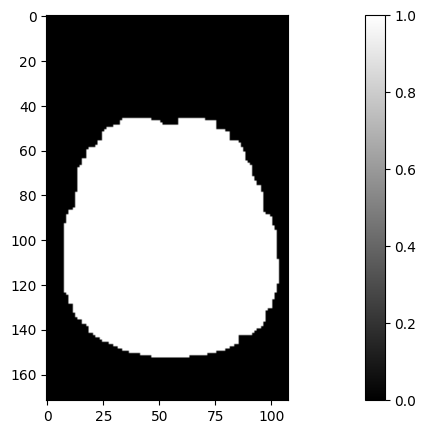

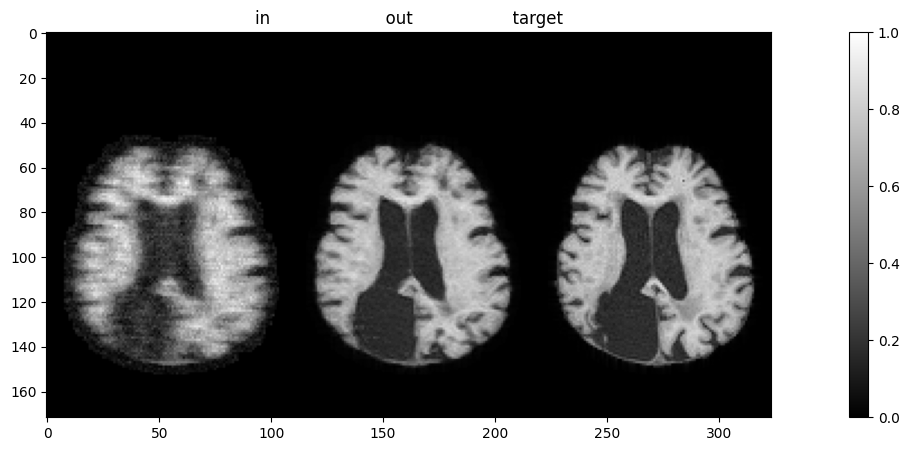

In [9]:
import numpy as np
from skimage.metrics import structural_similarity as ssim, peak_signal_noise_ratio as psnr, normalized_root_mse as nrmse
from skimage import img_as_float
from types import SimpleNamespace as Namespace


# Hyperparameters
params = Namespace()
params.data_path = "./test_data/patient29b"
params.batch_size = 1
params.num_grad_steps = 4
params.num_cg_steps = 8
params.share_weights = True
params.modl_lamda = 0.05
params.lr = 0.00001
params.weight_decay = 0
params.lr_step_size = 10
params.lr_gamma = 0.5
params.epoch = 21
params.reference_mode = 0
params.reference_lambda = 0.1

# Load test data
test_loader = create_data_loaders(params)

# Initialize lists to store metrics
mse_in_list, mse_out_list = [], []
psnr_in_list, psnr_out_list = [], []
ssim_in_list, ssim_out_list = [], []
recon_sum, inp_sum, tar_sum = torch.zeros((1,3,172,108)), torch.zeros((1,3,172,108)), torch.zeros((1,3,172,108))

fid_in = FrechetInceptionDistance(feature=64,normalize=True,input_img_size=(3, 172, 108))
fid_out = FrechetInceptionDistance(feature=64,normalize=True,input_img_size=(3, 172, 108))

single_MoDL.eval()  # Set model to evaluation mode
for i in range(10):
    with torch.no_grad():  # Disable gradient computation for evaluation
        for data in test_loader:
            input, target, mask, reference = data
            input = input.to(device)
            reference = reference.to(device)
            mask = mask.to(device)
            # Forward pass through the model
            output = single_MoDL(input.float(),reference_image=reference, mask=mask)
        
            # Handle output
            kspace_out = T.fft2(output.cpu().squeeze(0))
            im_out = T.ifft2(kspace_out)
        
            kspace_target = T.fft2(target.cpu().squeeze(0))
            target = T.ifft2(kspace_target)

        
            #print(cplx.to_numpy(im_out.cpu()).shape)
            cplx_image_target = cplx.to_numpy(target.cpu())
            cplx_image_in = cplx.to_numpy(T.ifft2(input.cpu())).squeeze(0)
            cplx_image_out = cplx.to_numpy(im_out.cpu().squeeze(0))
            cplx_image_reference = cplx.to_numpy(reference.cpu()).squeeze(0)
    

            target_numpy = cplx.to_numpy(target.cpu())
            input_numpy = cplx.to_numpy(T.ifft2(input.cpu())).squeeze(0)
            out_numpy = cplx.to_numpy(output.cpu()).squeeze(0)
            max_val = np.max(np.abs(np.concatenate((target_numpy,input_numpy,out_numpy),axis=0)))
            min_val = np.min(np.abs(np.concatenate((cplx_image_target,cplx_image_in,cplx_image_out),axis=0)))
            target_numpy_norm = np.abs(target_numpy)/max_val.squeeze(0)
            input_numpy_norm = np.abs(input_numpy)/max_val.squeeze(0)
            out_numpy_norm = np.abs(out_numpy)/max_val.squeeze(0)

        
            # Find comparison area:
            area = target_numpy_norm > 0.30
            kernel = np.ones((10, 10)) / 25.0
            #area = np.convolve(area, kernel, mode='constant', cval=0.0)
            area = scipy.ndimage.convolve(area.astype(float), kernel, mode='constant', cval=0.0)
            area[area>0.009] = 1
            structuring_element = np.ones((4,4))
            area = binary_closing(area, structure=structuring_element)
            area = binary_fill_holes(area)

            target_numpy_norm = target_numpy_norm * area
            input_numpy_norm = input_numpy_norm * area
            out_numpy_norm = out_numpy_norm * area
        
            # Calculate metrics
            # Calculate SSIM values
            data_range = max_val - min_val

            ssim_in, _ = ssim(target_numpy_norm, input_numpy_norm, data_range=data_range, full=True)
            ssim_out, _ = ssim(target_numpy_norm, out_numpy_norm, data_range=data_range, full=True)


            # Calculate PSNR
            psnr_in = T.PSNR_numpy(target_numpy_norm, input_numpy_norm)
            psnr_out = T.PSNR_numpy(target_numpy_norm, out_numpy_norm)


            # FID calc
            zeros_vec = torch.zeros((1,1,172,108))
            tar = torch.cat((cplx.to_tensor(np.abs(target_numpy_norm)).permute(2,0,1).unsqueeze(0),zeros_vec),dim=1)
            tar_sum = torch.cat((tar_sum,tar),dim=0)
            recon = torch.cat((cplx.to_tensor(np.abs(out_numpy_norm)).permute(2,0,1).unsqueeze(0),zeros_vec),dim=1)
            recon_sum = torch.cat((recon_sum,recon),dim=0)
            inp = torch.cat((cplx.to_tensor(np.abs(input_numpy_norm)).permute(2,0,1).unsqueeze(0),zeros_vec),dim=1) 
            inp_sum = torch.cat((inp_sum,inp),dim=0)       

            #print(img_in.shape)
            #print(img_out.shape)
            #print(img_target.shape)
            """
            plt_concat = np.concatenate((np.abs(cplx_image_reference),np.abs(cplx_image_in),np.abs(cplx_image_out),np.abs(cplx_image_target)),axis=1)
            fig, axs = plt.subplots(1, 1, figsize=(20, 5))  # 1 row, 3 columns
            im = axs.imshow(plt_concat, cmap='gray')
            axs.set_title(f'Reference                 Input (PSNR: {psnr_in:.2f})               Output (PSNR: {psnr_out:.2f})               Target')
        

            plt_concat = np.concatenate((np.abs( cplx.to_numpy(input.cpu()).squeeze(0)),np.abs(cplx.to_numpy(kspace_out)),np.abs(cplx.to_numpy(kspace_target))),axis=1)
            fig, axs = plt.subplots(1, 1, figsize=(20, 5))  # 1 row, 3 columns
            im = axs.imshow(np.log(plt_concat), cmap='gray')
            axs.set_title(f'Input (PSNR: {psnr_in:.2f})               Output (PSNR: {psnr_out:.2f})               Target')
            """   
            # Calculate MSE
            mse_in = np.mean(np.abs(input_numpy_norm-target_numpy_norm)**2)
            mse_out = np.mean(np.abs(out_numpy_norm-target_numpy_norm)**2)

            # Append metrics to lists
            mse_in_list.append(mse_in)
            mse_out_list.append(mse_out)
            psnr_in_list.append(psnr_in)
            psnr_out_list.append(psnr_out)
            ssim_in_list.append(ssim_in)
            ssim_out_list.append(ssim_out)

fid_in.update(tar_sum, real=True)
fid_out.update(tar_sum, real=True)
fid_out.update(recon_sum, real=False)
fid_recon = fid_out.compute()
fid_in.update(inp_sum, real=False)
fid_inp = fid_in.compute()
# Calculate and print average metrics
print(f'Average MSE input: {np.mean(mse_in_list):.4f}')
print(f'Average MSE output: {np.mean(mse_out_list):.4f}')
print(f'Average PSNR input: {np.mean(psnr_in_list):.4f}')
print(f'Average PSNR output: {np.mean(psnr_out_list):.4f}')
print(f'Average SSIM input: {np.mean(ssim_in_list):.4f}')
print(f'Average SSIM output: {np.mean(ssim_out_list):.4f}')
print(f'Average FID input: {fid_inp:.4f}')
print(f'Average FID output: {fid_recon:.4f}')
print(f'Test slices: {len(test_loader)}')

fig, axs = plt.subplots(1, 1, figsize=(20, 5))  # 1 row, 3 columns
im = axs.imshow(np.abs(area), cmap='gray')
fig.colorbar(im, ax=axs)
plt.show()

fig, axs = plt.subplots(1, 1, figsize=(20, 5))  # 1 row, 3 columns
im = axs.imshow(np.abs(np.concatenate((input_numpy_norm,out_numpy_norm,target_numpy_norm),axis=1)), cmap='gray')
axs.set_title('in                      out                   target')
fig.colorbar(im, ax=axs)
plt.show()